In [ ]:
import random
import numpy as np
import tensorflow as tf

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import Input

In [ ]:
# Load dataset
df = pd.read_csv("/content/updated_miniproject_dataset_one_hot.csv")
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Feature engineering
df['day_of_year'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

# Select only required columns
use_cols = [
    'avg_min_price', 'avg_max_price', 'district_name', 'calculationType',
    'change', 'paddy', 'ragi', 'jowar', 'moongdal', 'max_temp', 'min_temp',
    'avg_temp', 'rainfall', 'max_windspeed', 'min_windspeed', 'mean_windspeed',
     'day_of_year', 'month', 'weekday','summer', 'rainy', 'winter'
]


In [ ]:
# Drop NaNs
df = df[use_cols + ['avg_modal_price']].dropna().reset_index(drop=True)

# Separate features and target
X = df[use_cols]
y = df['avg_modal_price']

# Encoding categorical features if needed
X = pd.get_dummies(X, columns=['district_name', 'calculationType'], drop_first=True)

# Split
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

In [ ]:
# Scaling
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))

# Combine
train_combined = np.hstack([y_train_scaled, X_train_scaled])
val_combined = np.hstack([y_val_scaled, X_val_scaled])

In [ ]:
# Sequence generator
def create_sequences(data, window_size=90):
    X_seq, y_seq = [], []
    for i in range(window_size, len(data)):
        X_seq.append(data[i - window_size:i])
        y_seq.append(data[i, 0])
    return np.array(X_seq), np.array(y_seq)

# Build sequences
window_size = 90
X_train_seq, y_train_seq = create_sequences(train_combined, window_size)
X_val_seq, y_val_seq = create_sequences(val_combined, window_size)

In [ ]:
# LSTM Model
model = Sequential()
model.add(Input(shape=(window_size, X_train_seq.shape[2])))  # Best practice
model.add(LSTM(160, return_sequences=True))  # lstm_units1 = 160
model.add(Dropout(0.2))                      # dropout_rate = 0.2
model.add(LSTM(96, return_sequences=False, kernel_regularizer=l2(0.0001)))  # lstm_units2 = 96, l2_reg = 0.0001
model.add(Dropout(0.2))                      # dropout_rate = 0.2
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [ ]:
# Train
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=300,
    batch_size=16,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0328 - val_loss: 0.0157
Epoch 2/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 3/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0071 - val_loss: 0.0085
Epoch 4/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0058 - val_loss: 0.0091
Epoch 5/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 6/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 7/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 8/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 9/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0033 - val_loss: 0.0057
Epoch 10/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 11/300
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0030 - val_loss: 0.0052
Epoch 12/300
246/246 ━━━━━━━━━

In [ ]:
# Evaluate
y_val_pred = model.predict(X_val_seq)
mse = mean_squared_error(y_val_seq, y_val_pred)
r2 = r2_score(y_val_seq, y_val_pred)

print(f"Validation MSE: {mse:.6f}")
print(f"Validation R² Score: {r2:.6f}")

y_train_pred = model.predict(X_train_seq)
train_mse = mean_squared_error(y_train_seq, y_train_pred)
train_r2 = r2_score(y_train_seq, y_train_pred)

print(f"Training MSE: {train_mse:.6f}")
print(f"Training R² Score: {train_r2:.6f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Validation MSE: 0.004863
Validation R² Score: 0.791707
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Training MSE: 0.002155
Training R² Score: 0.929226


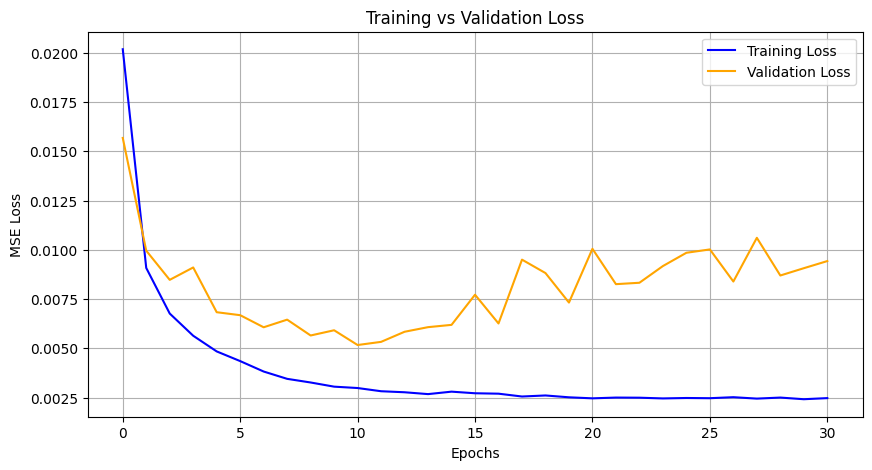

In [ ]:
import matplotlib.pyplot as plt

# 1. Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


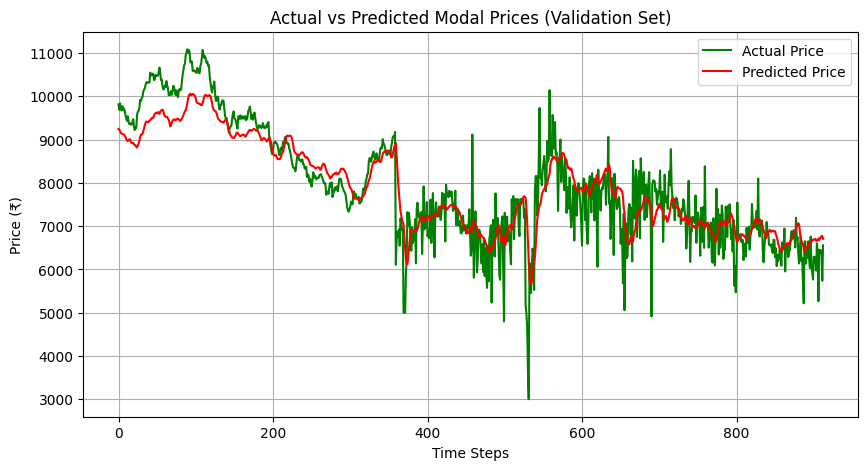

In [ ]:
# Inverse transform predictions and actuals to get real price values
y_val_pred_real = y_scaler.inverse_transform(y_val_pred)
y_val_real = y_scaler.inverse_transform(y_val_seq.reshape(-1, 1))

# 2. Actual vs Predicted Prices (Validation)
plt.figure(figsize=(10, 5))
plt.plot(y_val_real, label='Actual Price', color='green')
plt.plot(y_val_pred_real, label='Predicted Price', color='red')
plt.title("Actual vs Predicted Modal Prices (Validation Set)")
plt.xlabel("Time Steps")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.show()


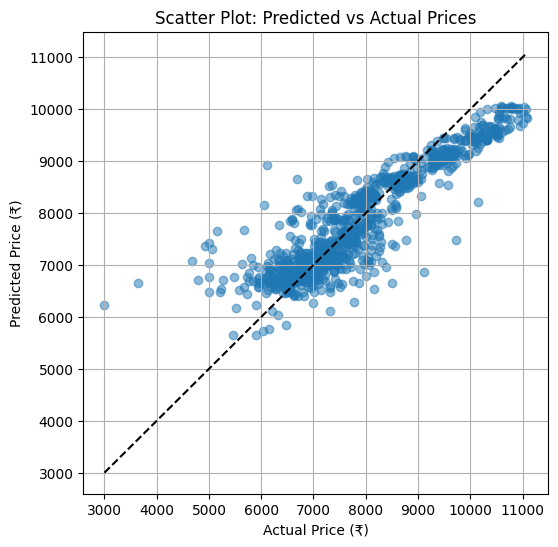

In [ ]:
# 3. Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val_real, y_val_pred_real, alpha=0.5)
plt.plot([y_val_real.min(), y_val_real.max()], [y_val_real.min(), y_val_real.max()], 'k--')
plt.xlabel("Actual Price (₹)")
plt.ylabel("Predicted Price (₹)")
plt.title("Scatter Plot: Predicted vs Actual Prices")
plt.grid(True)
plt.show()


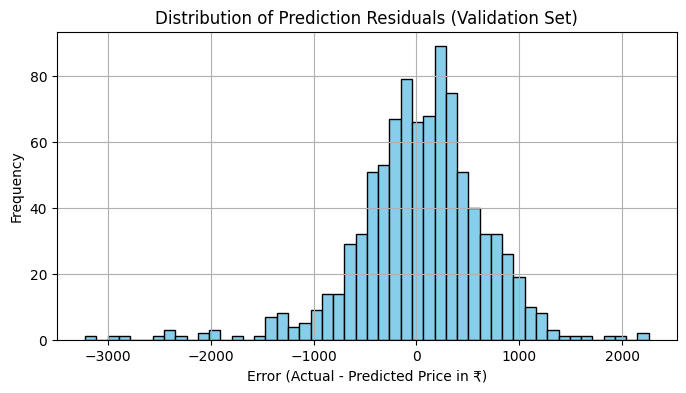

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals (prediction errors)
residuals = y_val_real - y_val_pred_real

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Residuals (Validation Set)")
plt.xlabel("Error (Actual - Predicted Price in ₹)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

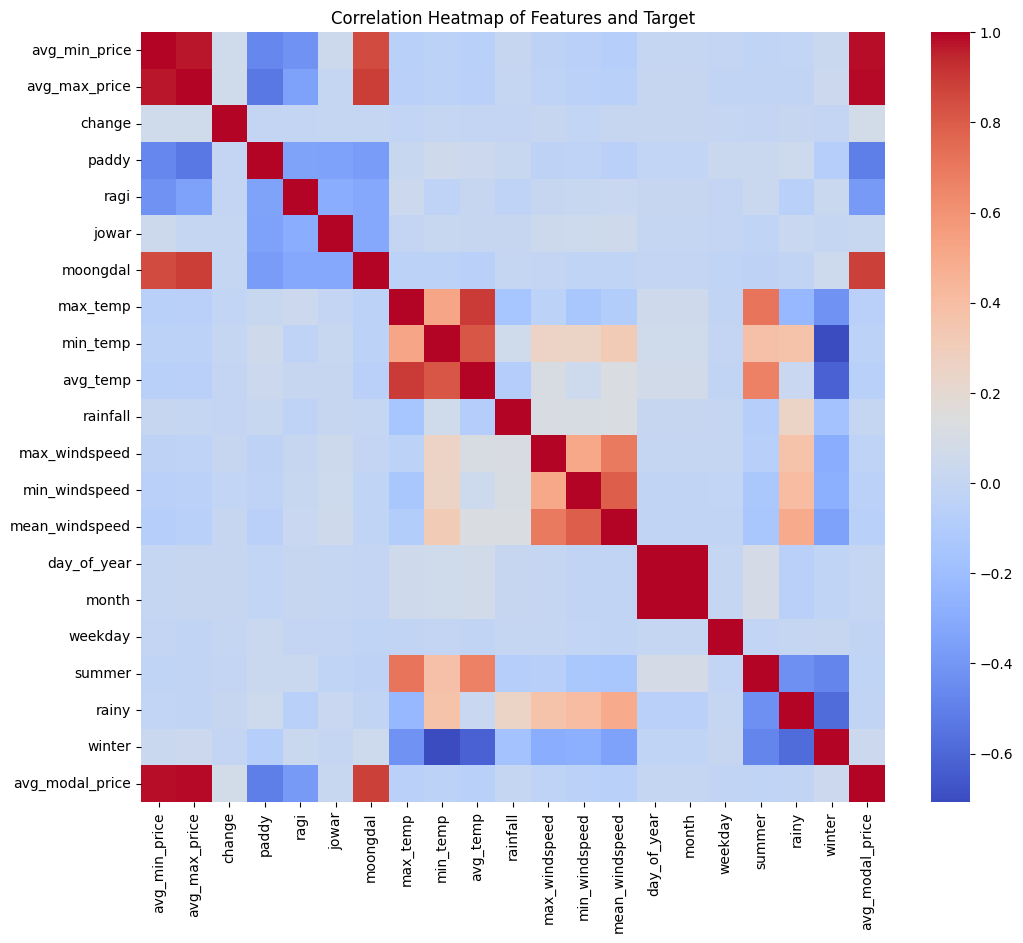

In [ ]:
import seaborn as sns

# Merge features and target
combined_df = X.copy()
combined_df['avg_modal_price'] = y

# Optional: reduce dimension for faster heatmap if needed
plt.figure(figsize=(12, 10))
sns.heatmap(combined_df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Features and Target")
plt.show()


In [ ]:

def predict_price(target_commodity, target_date_str):
    import datetime

    target_date = pd.to_datetime(target_date_str, dayfirst=True)

    day_of_year = target_date.dayofyear
    month = target_date.month
    weekday = target_date.weekday()


    last_rows = df.copy().tail(window_size).reset_index(drop=True)

    avg_weather = last_rows[[
        'max_temp', 'min_temp', 'avg_temp', 'rainfall',
        'max_windspeed', 'min_windspeed', 'mean_windspeed',
        'summer', 'rainy', 'winter'
    ]].mean()

    last_row = last_rows.iloc[-1].copy()
    last_row['day_of_year'] = day_of_year
    last_row['month'] = month
    last_row['weekday'] = weekday

    for col in avg_weather.index:
        last_row[col] = avg_weather[col]


    commodities = ['paddy', 'ragi', 'jowar', 'moongdal']
    for com in commodities:
        last_row[com] = 1 if com == target_commodity else 0


    last_row.drop('avg_modal_price', inplace=True)


    input_df = pd.DataFrame([last_row])
    input_df = pd.get_dummies(input_df, columns=['district_name', 'calculationType'], drop_first=True)


    missing_cols = set(X_train.columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 0
    input_df = input_df[X_train.columns]


    scaled_input = X_scaler.transform(input_df)

    prior_scaled = X_train_scaled[-(window_size - 1):]


    input_sequence = np.vstack([prior_scaled, scaled_input])
    input_sequence = input_sequence.reshape(1, window_size, input_sequence.shape[1])


    pred_scaled = model.predict(input_sequence)
    pred_price = y_scaler.inverse_transform(pred_scaled)[0][0]

    print(f"Predicted price for {target_commodity} on {target_date.strftime('%d-%m-%Y')}: ₹{pred_price:.2f}")
    return pred_price

# INPUT
commodity=input("Enter the commodity: ")
date=input("Enter the date: " )
predict_price(commodity, date)


Enter the commodity: paddy
Enter the date: 06-05-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted price for paddy on 06-05-2025: ₹1924.51


np.float32(1924.5099)